## Problem Objective:

#### Help the City of Los Angeles to structure and analyze its job descriptions

![City of LA](https://www.lacity.org/sites/g/files/wph1196/f/styles/large_hero_1920_x_700/public/bigstock-Human-Resources-Interview-Recr-116624942.jpg?itok=WoA_6y_C)

The City of Los Angeles faces a big hiring challenge: 1/3 of its 50,000 workers are eligible to retire by July of 2020. The city has partnered with Kaggle to create a competition to improve the job bulletins that will fill all those open positions.

The content, tone, and format of job bulletins can influence the quality of the applicant pool. Overly-specific job requirements may discourage diversity. The Los Angeles Mayor’s Office wants to reimagine the city’s job bulletins by using text analysis to identify needed improvements.

The goal is to convert a folder full of plain-text job postings into a structured CSV file and then to use this data to: 

(1) identify language that can negatively bias the pool of applicants; 

(2) improve the diversity and quality of the applicant pool; and/or 

(3) make it easier to determine which promotions are available to employees in each job class.

In [1]:
# Import python packages
import os
from os import walk
import shutil
from shutil import copytree, ignore_patterns
from PIL import Image
from wand.image import Image as Img
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

%matplotlib inline

## Introduction

Thanks to Paul Mooney's [Kernel](https://www.kaggle.com/paultimothymooney/explore-job-postings), let us first start by looking at some of the job postings to get an idea of how they look like.

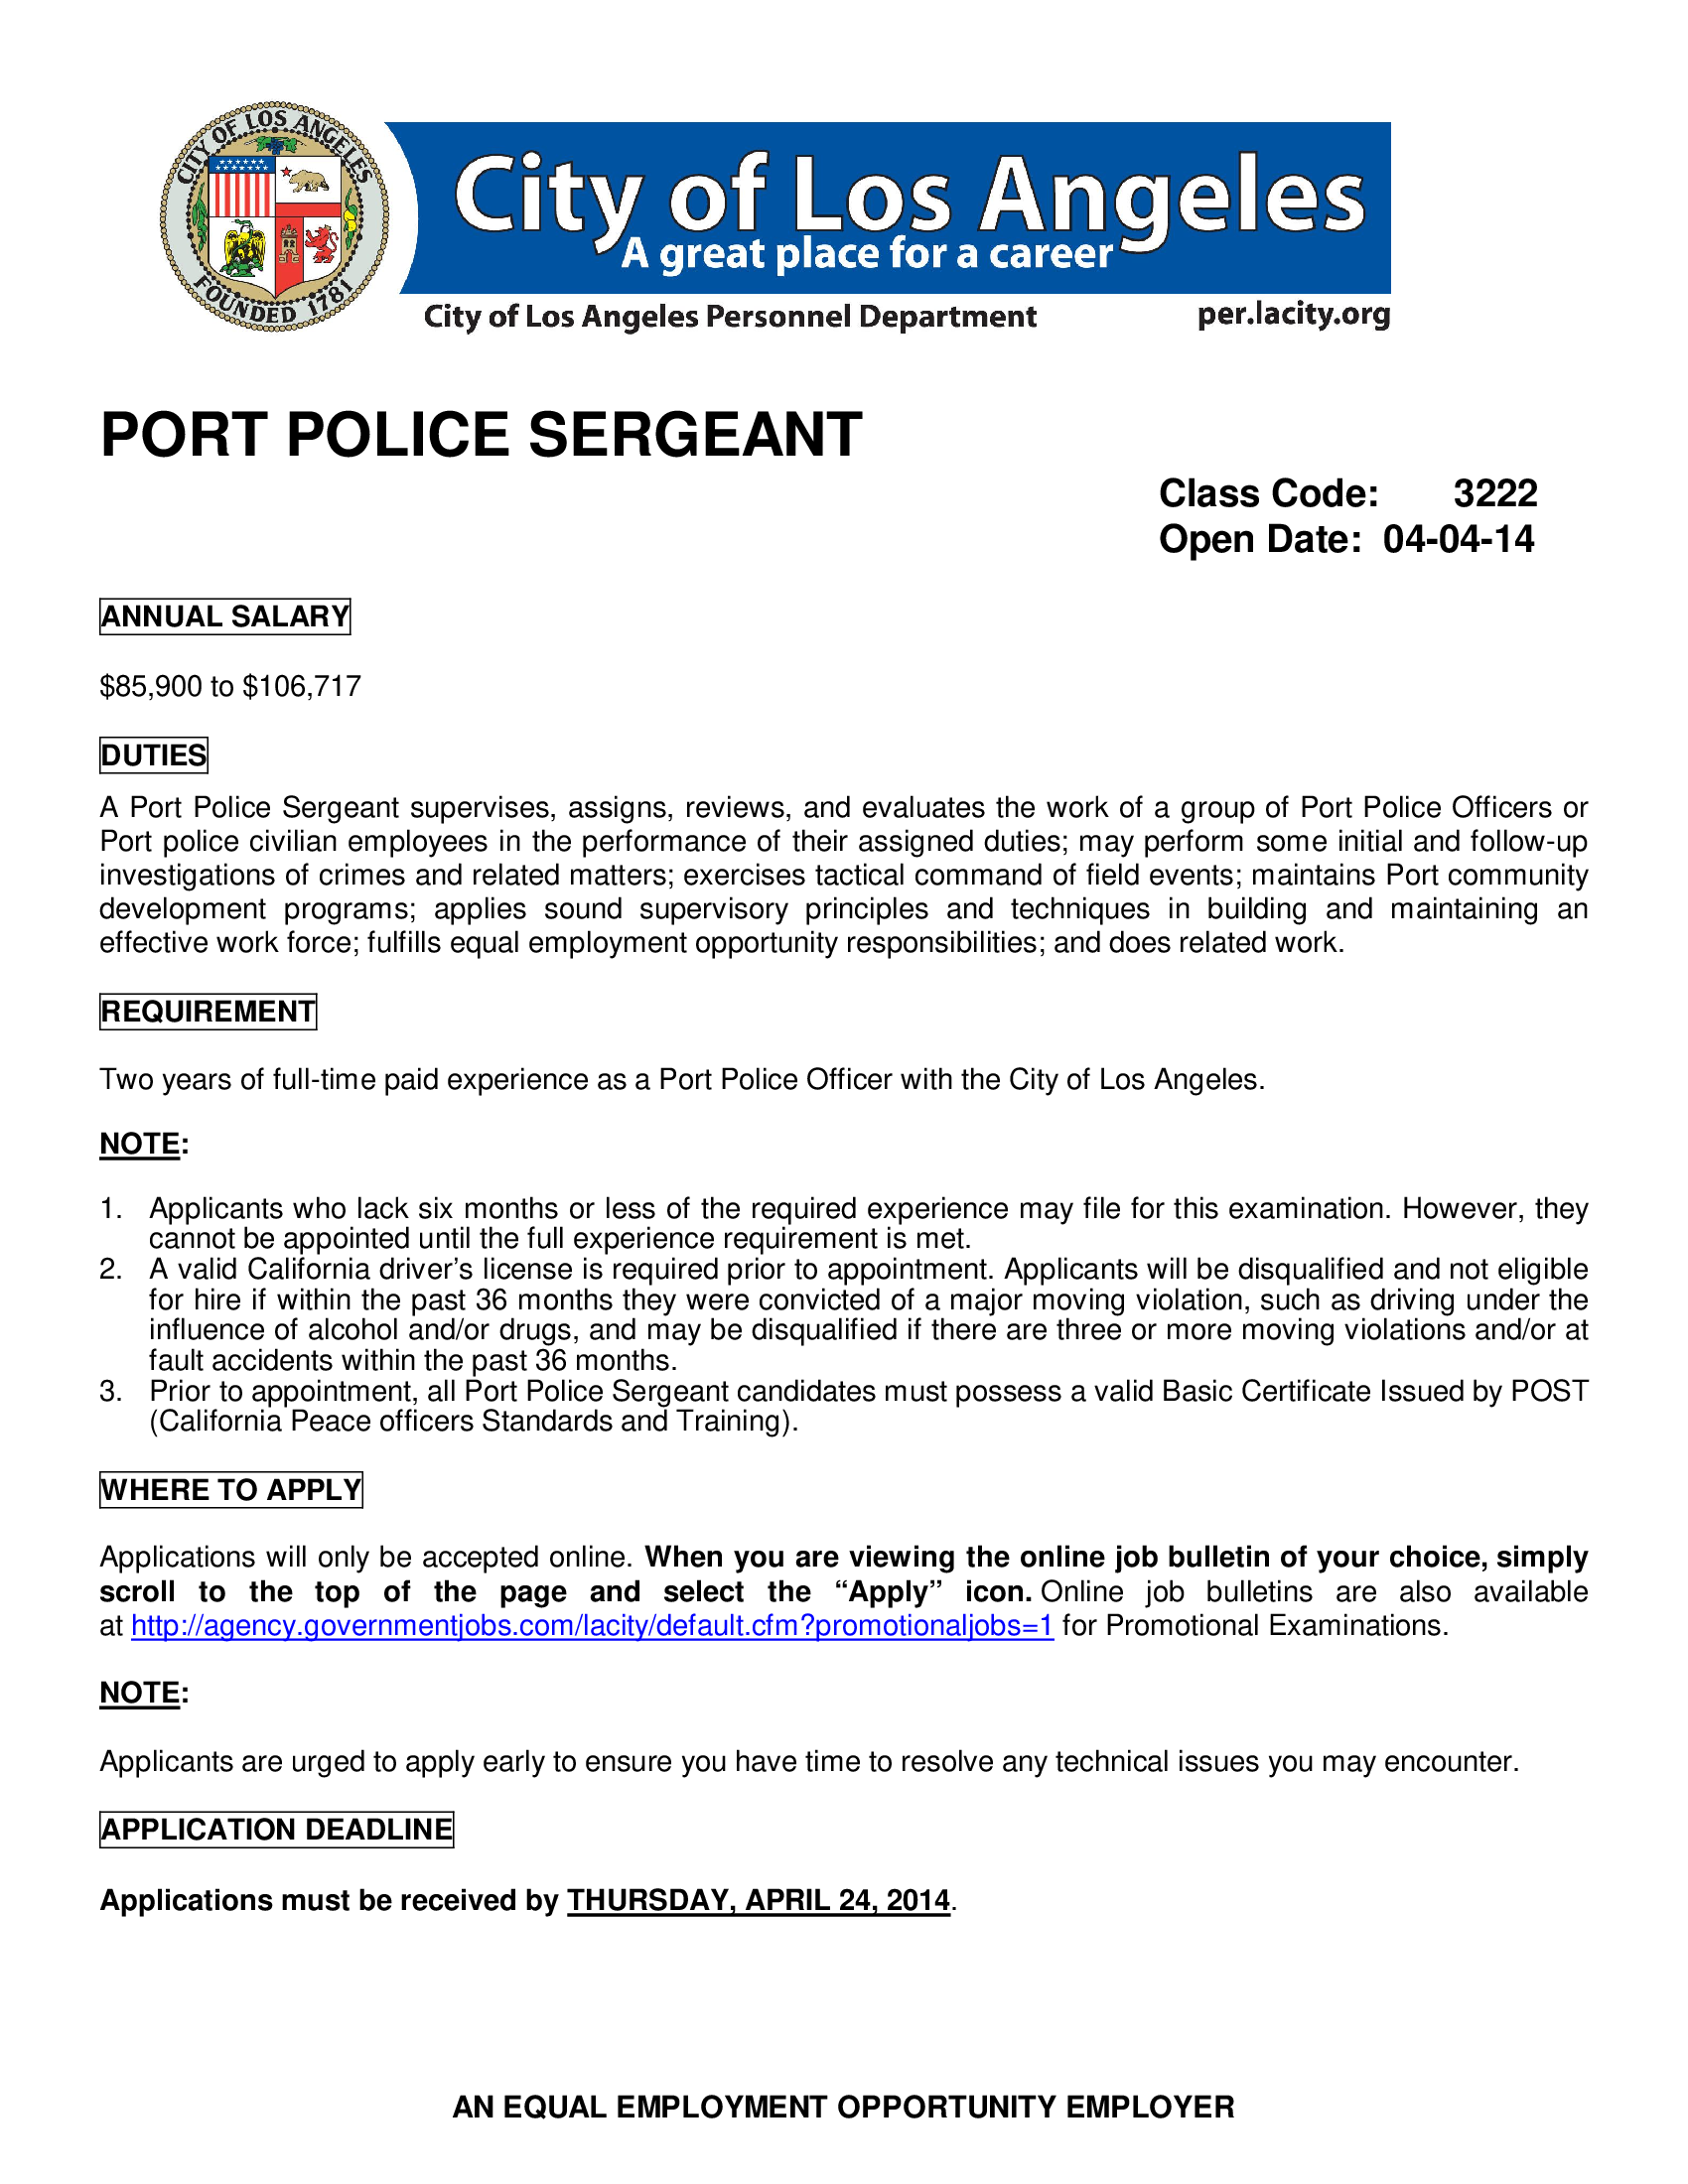

In [2]:
pdf = '../input/cityofla/CityofLA/Additional data/PDFs/2014/April 2014/040414/PORT POLICE SERGEANT 3222.pdf'
Img(filename=pdf, resolution=200)

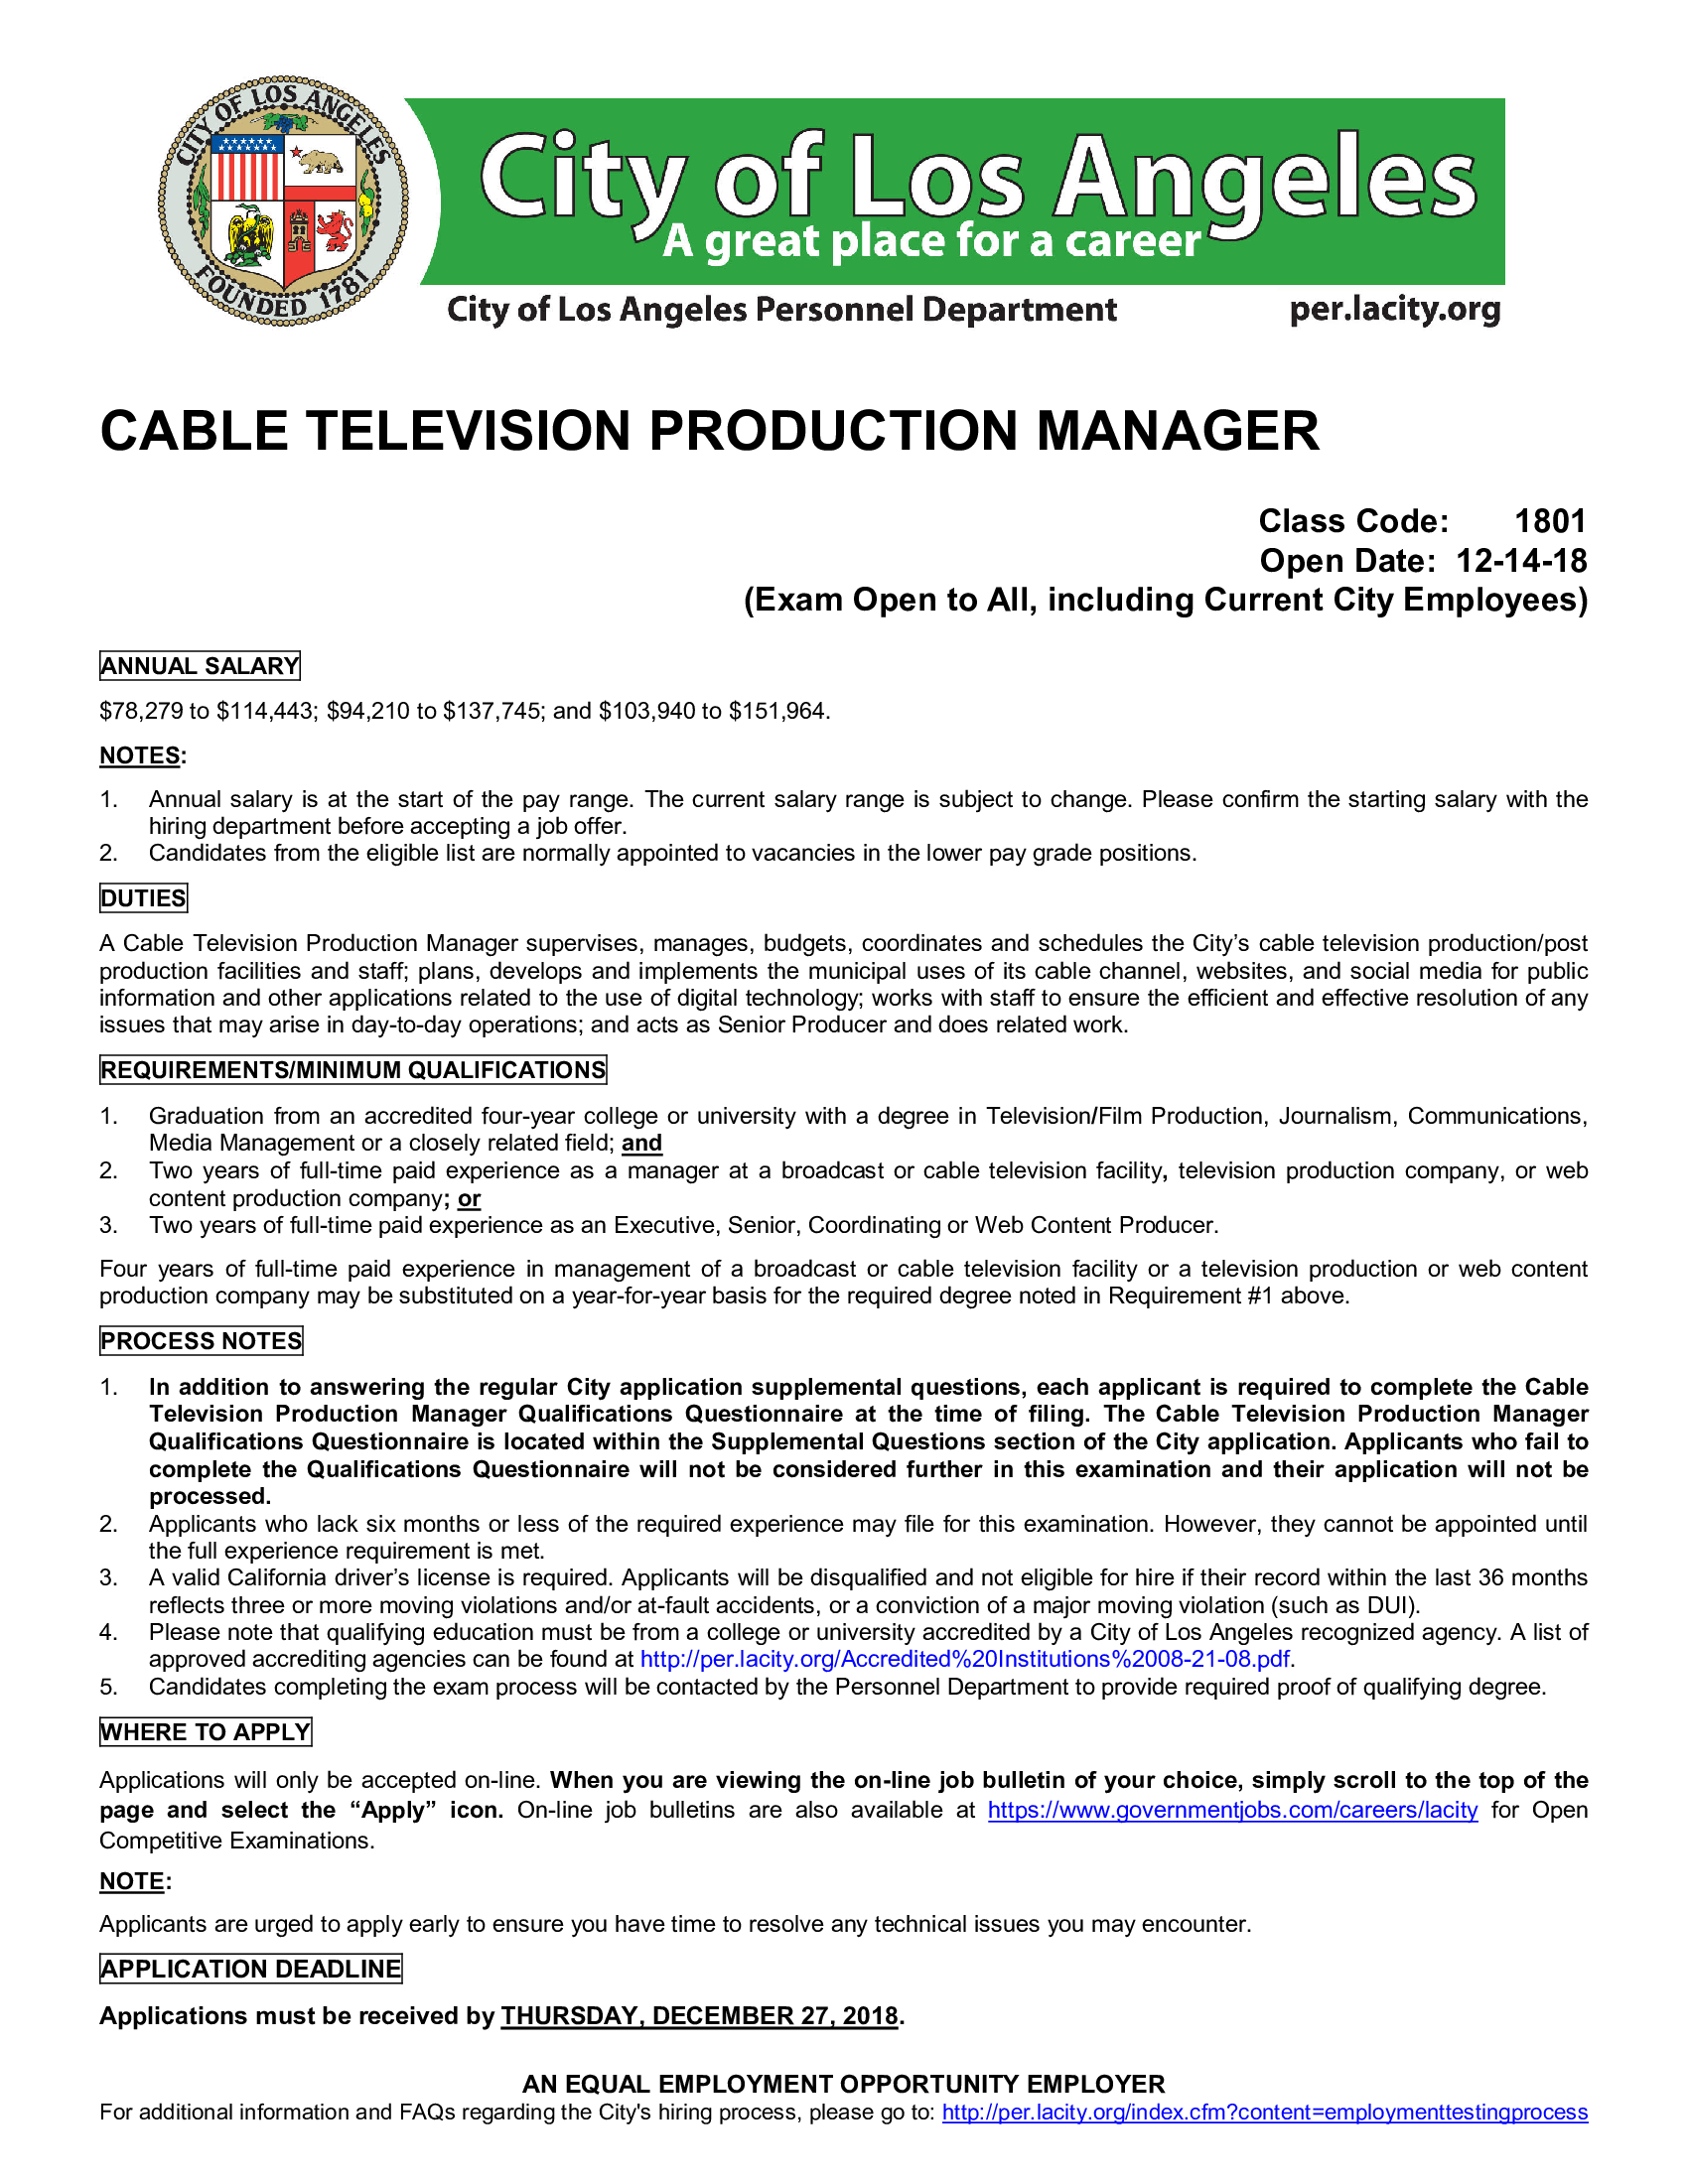

In [3]:
pdf = '../input/cityofla/CityofLA/Additional data/PDFs/2018/December/Dec 14/CABLE TELEVISION PRODUCTION MANAGER 1801 121418.pdf'
Img(filename=pdf, resolution=200)

Looks like the job postings have a generic format which they adhere to like 

1. Job Title at the first line
2. Job code in the next line
3. Job open date in the next line 
4. Annual Salary in the next part
5. Duties in the next part
6. Requirements / Qualifications in the next part
7. Where to apply information
8. Application deadline information

So the aim of the contest (as well as this notebook) is to parse the application and to get some structured information out of these files. Also we will do some analysis to understand the content of the job postings.

We have also got a sample template on how the parsed file will look like. Let us have a look at it. 

In [4]:
sample_output_df = pd.read_csv("../input/cityofla/CityofLA/Additional data/sample job class export template.csv")
sample_output_df.head(3)

,FILE_NAME,JOB_CLASS_TITLE,JOB_CLASS_NO,REQUIREMENT_SET_ID,REQUIREMENT_SUBSET_ID,JOB_DUTIES,EDUCATION_YEARS,SCHOOL_TYPE,EDUCATION_MAJOR,EXPERIENCE_LENGTH,FULL_TIME_PART_TIME,EXP_JOB_CLASS_TITLE,EXP_JOB_CLASS_ALT_RESP,EXP_JOB_CLASS_FUNCTION,COURSE_COUNT,COURSE_LENGTH,COURSE_SUBJECT,MISC_COURSE_DETAILS,DRIVERS_LICENSE_REQ,DRIV_LIC_TYPE,ADDTL_LIC,EXAM_TYPE,ENTRY_SALARY_GEN,ENTRY_SALARY_DWP,OPEN_DATE
0,SYSTEMS ANALYST 1596 102717.txt,Systems Analyst,1596,1,A,"A Systems Analyst analyzes procedures, methods...",4.0,COLLEGE OR UNIVERSITY,COMPUTER SCIENCE|INFORMATION SYSTEMS|GEOGRAPHI...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OPEN_INT_PROM,68611-100307,70908-88092,10/27/17
1,SYSTEMS ANALYST 1596 102717.txt,Systems Analyst,1596,2,A,"A Systems Analyst analyzes procedures, methods...",4.0,COLLEGE OR UNIVERSITY,NaN,2.0,FULL-TIME,MANAGEMENT ASSISTANT,NaN,"the development, analysis, implementation or m...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,OPEN_INT_PROM,68611-100307,70908-88092,10/27/17
2,SYSTEMS ANALYST 1596 102717.txt,Systems Analyst,1596,2,B,"A Systems Analyst analyzes procedures, methods...",4.0,COLLEGE OR UNIVERSITY,NaN,2.0,FULL-TIME,MANAGEMENT ASSISTANT,NaN,"performing cost benefit, feasibility and requi...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,OPEN_INT_PROM,68611-100307,70908-88092,10/27/17


We need to extract the contents and make it structureds like the above one. We also need to create a data dictionary like the below one for the created fields.

In [5]:
data_dict_df = pd.read_csv("../input/cityofla/CityofLA/Additional data/kaggle_data_dictionary.csv")
data_dict_df.head()

,Field Name,Annotation Letter,Description,Data Type,Allowable Values,Accepts Null Values?,Additional Notes
0,FILE_NAME,NaN,The file name of the job bulletin from which e...,String,NaN,No,NaN
1,JOB_CLASS_TITLE,A,"The title of the particular class (e.g., Syste...",String,Any job title matching in in supplied job bull...,No,NaN
2,JOB_CLASS_NO,B,The 4-digit code that corresponds to the job c...,String,Any four character numeric string matching one...,No,Some classes have three non-zero digits — e.g....
3,REQUIREMENT_SET_ID,D1,A main requirement that has to be filled. Thes...,Integer,Any positive integer,No,NaN
4,REQUIREMENT_SUBSET_ID,D2,"A secondary requirement that has to be filled,...",String,Any letter or combination of letters.,No,"A-Z represents 1-26. In the case of 27th, 28th..."


We are also given the job descriptions in plain text files. Let us get the total number of files and have a look at top few lines of one of the files.

In [6]:
job_bulletins_path = "../input/cityofla/CityofLA/Job Bulletins/"
print("Number of Job bulletins : ",len(os.listdir(job_bulletins_path)))

Number of Job bulletins :  683


In [7]:
with open(job_bulletins_path + os.listdir(job_bulletins_path)[0]) as f: 
    print (f.read(1000))

WATER SERVICE REPRESENTATIVE
Class Code:       1693
Open Date:  11-17-17
(Exam Open to Current City Employees)

ANNUAL SALARY

$70,177 to $87,194 and $74,750 to $92,895
Candidates from the eligible list are normally appointed to vacancies in the lower pay grade positions. 

NOTES:

1. For information regarding reciprocity between the City of Los Angeles departments and LADWP, go to http://per.lacity.org/Reciprocity_CityDepts_and_DWP.pdf.
2. Annual salary is at the start of the pay range. The current salary range is subject to change. Please confirm the starting salary with the hiring department before accepting a job offer.


DUTIES

A Water Service Representative makes field investigations to determine water service requirements; advises and consults with customers or their representatives in the office, on the telephone or in the field regarding water service requirements, agreements, problems, irregularities, and complaints; determines and collects applicable charges and rates; issu

## Data Extraction

In this section, let us extract the data and create a structured table out of it.


In [8]:
jobs_list = []
for file_name in os.listdir(job_bulletins_path):
    with open(job_bulletins_path + file_name, encoding = "ISO-8859-1") as f:
        content = f.read()
        jobs_list.append([file_name, content])
jobs_df = pd.DataFrame(jobs_list)
jobs_df.columns = ["FileName", "Content"]
jobs_df.head()

,FileName,Content
0,WATER SERVICE REPRESENTATIVE 1693 111717.txt,WATER SERVICE REPRESENTATIVE\nClass Code: ...
1,HARBOR PLANNING AND ECONOMIC ANALYST 9224 1118...,HARBOR PLANNING AND ECONOMIC ANALYST\n\n\t\t\t...
2,MANAGING WATER UTILITY ENGINEER 9406 032417 RE...,MANAGING WATER UTILITY ENGINEER\n\nClass Code:...
3,VETERINARY TECHNICIAN 2369 020599 REV 120417.txt,VETERINARY TECHNICIAN \t\t\t\t \t \n...
4,SENIOR UTILITY SERVICES SPECIALIST 3573 113018...,SENIOR UTILITY SERVICES SPECIALIST\n\nClass Co...


#### Job Class Title

We can see that the first line of the file represents the job title. So let us start with extracting them.

To extract the job title, we are going to split by new line character and then get the first line. There are three instances where first line is "Campus interviews only" and so we need to take the second line for those documents.

In [9]:
def extract_title(text):
    text = text.replace("CAMPUS INTERVIEWS ONLY", "")
    return text.strip().split("\n")[0].split("\t")[0]

jobs_df["JobClassTitle"] = jobs_df["Content"].apply(lambda x: extract_title(x))
jobs_df.head()

,FileName,Content,JobClassTitle
0,WATER SERVICE REPRESENTATIVE 1693 111717.txt,WATER SERVICE REPRESENTATIVE\nClass Code: ...,WATER SERVICE REPRESENTATIVE
1,HARBOR PLANNING AND ECONOMIC ANALYST 9224 1118...,HARBOR PLANNING AND ECONOMIC ANALYST\n\n\t\t\t...,HARBOR PLANNING AND ECONOMIC ANALYST
2,MANAGING WATER UTILITY ENGINEER 9406 032417 RE...,MANAGING WATER UTILITY ENGINEER\n\nClass Code:...,MANAGING WATER UTILITY ENGINEER
3,VETERINARY TECHNICIAN 2369 020599 REV 120417.txt,VETERINARY TECHNICIAN \t\t\t\t \t \n...,VETERINARY TECHNICIAN
4,SENIOR UTILITY SERVICES SPECIALIST 3573 113018...,SENIOR UTILITY SERVICES SPECIALIST\n\nClass Co...,SENIOR UTILITY SERVICES SPECIALIST


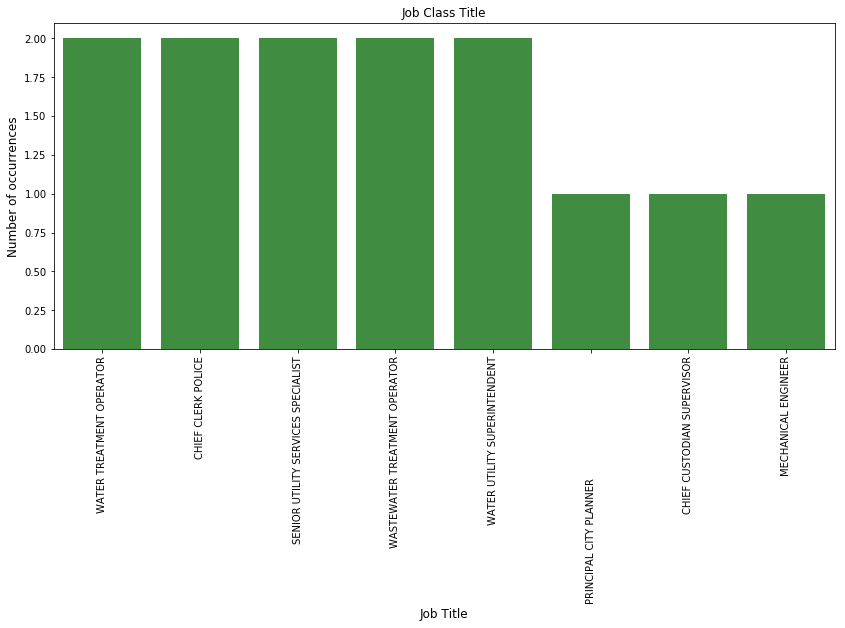

In [10]:
cnt_srs = jobs_df['JobClassTitle'].value_counts()[:8]
#cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('Job Title', fontsize=12)
plt.ylabel('Number of occurrences', fontsize=12)
plt.title("Job Class Title")
plt.show()

Only 5 job titles occur twice. Rest all occur only once. 

#### Job Class Code

In this section let us extract the job class code from the bulletins. We can see from the example files at the top that they occur next to job title and starts with "Class Code:". So let us extract the line having these words and then use them to extract job class code.

In [11]:
def extract_class_code(text):
    class_code = None
    for line in text.strip().split("\n"):
        if "Class Code:" in line:
            class_code = line.replace("Class Code:","").strip().split("\t")[0]
        elif "Class  Code:" in line:
            class_code = line.replace("Class  Code:","").strip().split("\t")[0]
    #if class_code is None:
    #    print(text.strip().split("\n"))
    #    raise
    return class_code
        

jobs_df["JobClassCode"] = jobs_df["Content"].apply(lambda x: extract_class_code(x))
jobs_df.head()

,FileName,Content,JobClassTitle,JobClassCode
0,WATER SERVICE REPRESENTATIVE 1693 111717.txt,WATER SERVICE REPRESENTATIVE\nClass Code: ...,WATER SERVICE REPRESENTATIVE,1693
1,HARBOR PLANNING AND ECONOMIC ANALYST 9224 1118...,HARBOR PLANNING AND ECONOMIC ANALYST\n\n\t\t\t...,HARBOR PLANNING AND ECONOMIC ANALYST,9224
2,MANAGING WATER UTILITY ENGINEER 9406 032417 RE...,MANAGING WATER UTILITY ENGINEER\n\nClass Code:...,MANAGING WATER UTILITY ENGINEER,9406
3,VETERINARY TECHNICIAN 2369 020599 REV 120417.txt,VETERINARY TECHNICIAN \t\t\t\t \t \n...,VETERINARY TECHNICIAN,2369
4,SENIOR UTILITY SERVICES SPECIALIST 3573 113018...,SENIOR UTILITY SERVICES SPECIALIST\n\nClass Co...,SENIOR UTILITY SERVICES SPECIALIST,3753


#### Open date

Now let us extract the open date of the job 

In [12]:
def extract_open_date(text):
    open_date = None
    for line in text.strip().split("\n"):
        if "Open Date:" in line:
            open_date = line.replace("Open Date:","").strip().split("\t")[0]
        elif "Open date:" in line:
            open_date = line.replace("Open date:","").strip().split("\t")[0]
#     if open_date is None:
#         print(text.strip().split("\n"))
#         raise
    return open_date
        

jobs_df["JobOpenDate"] = jobs_df["Content"].apply(lambda x: extract_open_date(x))
jobs_df.head()

,FileName,Content,JobClassTitle,JobClassCode,JobOpenDate
0,WATER SERVICE REPRESENTATIVE 1693 111717.txt,WATER SERVICE REPRESENTATIVE\nClass Code: ...,WATER SERVICE REPRESENTATIVE,1693,11-17-17
1,HARBOR PLANNING AND ECONOMIC ANALYST 9224 1118...,HARBOR PLANNING AND ECONOMIC ANALYST\n\n\t\t\t...,HARBOR PLANNING AND ECONOMIC ANALYST,9224,11-18-16
2,MANAGING WATER UTILITY ENGINEER 9406 032417 RE...,MANAGING WATER UTILITY ENGINEER\n\nClass Code:...,MANAGING WATER UTILITY ENGINEER,9406,03-24-17
3,VETERINARY TECHNICIAN 2369 020599 REV 120417.txt,VETERINARY TECHNICIAN \t\t\t\t \t \n...,VETERINARY TECHNICIAN,2369,02-05-99
4,SENIOR UTILITY SERVICES SPECIALIST 3573 113018...,SENIOR UTILITY SERVICES SPECIALIST\n\nClass Co...,SENIOR UTILITY SERVICES SPECIALIST,3753,11-30-18


#### Annual Salary

Now let us extract the annual salary from job bulletin

In [13]:
def extract_annual_salary(text):
    extracted_text = ""
    start = 0
    for line in text.strip().split("\n"):
        if "ANNUAL SALARY" in line or "ANNUALSALARY" in line:
            start = 1
        elif start and line.isupper():
            start = 0
        if start:
            extracted_text += line + "\n"
    extracted_text = extracted_text.replace("ANNUAL SALARY","").replace("ANNUALSALARY","").strip().split("\n")[0]
    
    ### Multiple salaries are available per job so extract all of them and save in a liot
    salary_list = []
    salary_split = extracted_text.split()
    for i, v in enumerate(salary_split):
        if v.lower() == "to":
            salary = salary_split[i-1] + " to " + salary_split[i+1]
            salary_list.append(salary)
    if len(salary_list) == 0:
        salary = extracted_text.split("and")
        salary_list.extend(salary)
    return salary_list
            
jobs_df["JobAnnualSalary"] = jobs_df["Content"].apply(lambda x: extract_annual_salary(x))
jobs_df.head(7)

,FileName,Content,JobClassTitle,JobClassCode,JobOpenDate,JobAnnualSalary
0,WATER SERVICE REPRESENTATIVE 1693 111717.txt,WATER SERVICE REPRESENTATIVE\nClass Code: ...,WATER SERVICE REPRESENTATIVE,1693,11-17-17,"[$70,177 to $87,194, $74,750 to $92,895]"
1,HARBOR PLANNING AND ECONOMIC ANALYST 9224 1118...,HARBOR PLANNING AND ECONOMIC ANALYST\n\n\t\t\t...,HARBOR PLANNING AND ECONOMIC ANALYST,9224,11-18-16,"[$70,908 to $103,648;, $78,571 to $114,903]"
2,MANAGING WATER UTILITY ENGINEER 9406 032417 RE...,MANAGING WATER UTILITY ENGINEER\n\nClass Code:...,MANAGING WATER UTILITY ENGINEER,9406,03-24-17,"[$148,561 to $184,579;, $156,850 to $194,873;,..."
3,VETERINARY TECHNICIAN 2369 020599 REV 120417.txt,VETERINARY TECHNICIAN \t\t\t\t \t \n...,VETERINARY TECHNICIAN,2369,02-05-99,"[$50,425 to $73,706]"
4,SENIOR UTILITY SERVICES SPECIALIST 3573 113018...,SENIOR UTILITY SERVICES SPECIALIST\n\nClass Co...,SENIOR UTILITY SERVICES SPECIALIST,3753,11-30-18,"[$117,199 to $145,596]"
5,PILE DRIVER WORKER 3553 041417.txt,PILE DRIVER WORKER\n\nClass Code: 3553\nOpen D...,PILE DRIVER WORKER,3553,04-14-17,"[$85,190 , $93,667 (flat-rated)]"
6,AUTO PAINTER 3721 022417.txt,AUTO PAINTER\nClass Code: 3721\nOpen Dat...,AUTO PAINTER,3721,02-24-17,"[$77,256 to $83,561]"


In [14]:
def clean_salary(salary):
    ### Remove commas and $ 
    return salary.replace("$","").replace(",", "").replace(";","").replace(";","").strip()

def get_nth_salary(salary_list, n):
    try:
        salary = salary_list[n]
    except:
        salary = None
    if salary is not None:
        salary = clean_salary(salary)
    return salary
    
jobs_df["JobAnnualSalary_1"] = jobs_df["JobAnnualSalary"].apply(lambda x: get_nth_salary(x, 0))
jobs_df["JobAnnualSalary_2"] = jobs_df["JobAnnualSalary"].apply(lambda x: get_nth_salary(x, 1))
jobs_df["JobAnnualSalary_3"] = jobs_df["JobAnnualSalary"].apply(lambda x: get_nth_salary(x, 2))
jobs_df["JobAnnualSalary_4"] = jobs_df["JobAnnualSalary"].apply(lambda x: get_nth_salary(x, 3))
jobs_df["JobAnnualSalary_5"] = jobs_df["JobAnnualSalary"].apply(lambda x: get_nth_salary(x, 4))
jobs_df["JobAnnualSalary_6"] = jobs_df["JobAnnualSalary"].apply(lambda x: get_nth_salary(x, 5))
jobs_df["JobAnnualSalary_7"] = jobs_df["JobAnnualSalary"].apply(lambda x: get_nth_salary(x, 6))
jobs_df["JobAnnualSalary_8"] = jobs_df["JobAnnualSalary"].apply(lambda x: get_nth_salary(x, 7))
jobs_df["JobAnnualSalary_9"] = jobs_df["JobAnnualSalary"].apply(lambda x: get_nth_salary(x, 8))
jobs_df["JobAnnualSalary_10"] = jobs_df["JobAnnualSalary"].apply(lambda x: get_nth_salary(x, 9))
jobs_df.head(7)

,FileName,Content,JobClassTitle,JobClassCode,JobOpenDate,JobAnnualSalary,JobAnnualSalary_1,JobAnnualSalary_2,JobAnnualSalary_3,JobAnnualSalary_4,JobAnnualSalary_5,JobAnnualSalary_6,JobAnnualSalary_7,JobAnnualSalary_8,JobAnnualSalary_9,JobAnnualSalary_10
0,WATER SERVICE REPRESENTATIVE 1693 111717.txt,WATER SERVICE REPRESENTATIVE\nClass Code: ...,WATER SERVICE REPRESENTATIVE,1693,11-17-17,"[$70,177 to $87,194, $74,750 to $92,895]",70177 to 87194,74750 to 92895,None,None,None,None,None,None,None,None
1,HARBOR PLANNING AND ECONOMIC ANALYST 9224 1118...,HARBOR PLANNING AND ECONOMIC ANALYST\n\n\t\t\t...,HARBOR PLANNING AND ECONOMIC ANALYST,9224,11-18-16,"[$70,908 to $103,648;, $78,571 to $114,903]",70908 to 103648,78571 to 114903,None,None,None,None,None,None,None,None
2,MANAGING WATER UTILITY ENGINEER 9406 032417 RE...,MANAGING WATER UTILITY ENGINEER\n\nClass Code:...,MANAGING WATER UTILITY ENGINEER,9406,03-24-17,"[$148,561 to $184,579;, $156,850 to $194,873;,...",148561 to 184579,156850 to 194873,190404 to 236549,201011 to 249745,212224 to 263672,None,None,None,None,None
3,VETERINARY TECHNICIAN 2369 020599 REV 120417.txt,VETERINARY TECHNICIAN \t\t\t\t \t \n...,VETERINARY TECHNICIAN,2369,02-05-99,"[$50,425 to $73,706]",50425 to 73706,None,None,None,None,None,None,None,None,None
4,SENIOR UTILITY SERVICES SPECIALIST 3573 113018...,SENIOR UTILITY SERVICES SPECIALIST\n\nClass Co...,SENIOR UTILITY SERVICES SPECIALIST,3753,11-30-18,"[$117,199 to $145,596]",117199 to 145596,None,None,None,None,None,None,None,None,None
5,PILE DRIVER WORKER 3553 041417.txt,PILE DRIVER WORKER\n\nClass Code: 3553\nOpen D...,PILE DRIVER WORKER,3553,04-14-17,"[$85,190 , $93,667 (flat-rated)]",85190,93667 (flat-rated),None,None,None,None,None,None,None,None
6,AUTO PAINTER 3721 022417.txt,AUTO PAINTER\nClass Code: 3721\nOpen Dat...,AUTO PAINTER,3721,02-24-17,"[$77,256 to $83,561]",77256 to 83561,None,None,None,None,None,None,None,None,None


### More to come. Stay tuned! 